In [44]:
%matplotlib inline

Single-subject example of SVM classification based on entire brain's voxels for CIMAQ memory encoding task (fMRI data). 

Trials (conditions) are classifierd according to either condition or memory performance (hit vs miss, correct vs incorrect source)


In [45]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel as nb
import sklearn
import seaborn as sns
import itertools

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nilearn import image, plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler

#libraries need to be installed in conda environment with pip install

Step 1: import brain imaging data

**Note: I am contrasting two different models: encoding trials modelled as separate regressors into one first-level model (MANY regressors...)
OR
a different model is created for each trial, where trials of no interest are modelled into two separate conditions (encoding or control)**


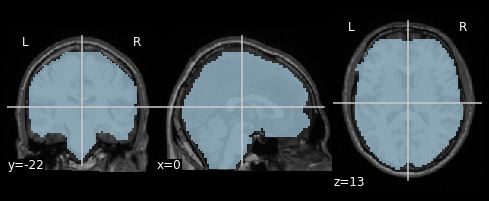

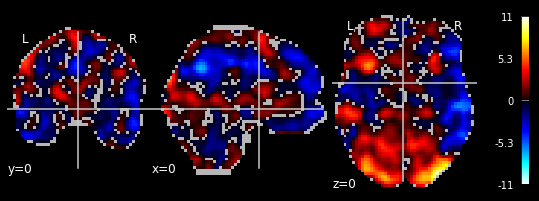

In [46]:
# subject dccid (identifier used in Loris-cimaq database)
id = '122922'

# Subject's anatomical scan (for display) and fMRI mask (normalized, non-linear)
# directory where subject's functional mask and anatomical scan both reside
anat_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922'
# load subject's anatomical scan as nibabel image
anat = nb.load(os.path.join(anat_dir, 'anat_sub122922_nuc_stereonl.nii'))
# load mask of subject's functional MRI data as nibabel image
mask = nb.load(os.path.join(anat_dir, 'func_sub122922_mask_stereonl.nii'))

# visualize functional mask superimposed on subjet's anatomical image
plot_roi(roi_img=mask, bg_img=anat, cmap='Paired')

# sanity check: 
# verify that the functional mask from the NIAK preprocessing output directory (anat)  
# overlaps completely with the fMRI voxels (task epi scans)
tscores = '/Users/mombot/Documents/Simexp/CIMAQ/Data/test/Output/122922/MultiModels/EncMinCTL_tscores_sub122922.nii'
plot_stat_map(stat_map_img=tscores, bg_img=mask, cut_coords=(0, 0, 0), threshold=0.2, colorbar=True)

# beta maps for ENCODING trials only, concatenated in temporal order (4D file)
# each trial is a 3D .nii file
# Note: a single model (design matrix) was used with a beta derived for each encoding trial (many regressors)
betas_enc4D = glob.glob('/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/SingleModel/concat*.nii')[0]

# beta maps for ALL trials, 
# uploaded and concatenate a series of 3D images (1 per trial) in nilearn using the wild card 
# Note1: temporal order MUST be preserved when scans are ordered alphabetically (use left-padding for trial numbers) 
# Note2: separate models (design matrix) were used for each trial (1 beta for trial of interest, other trials bunched together)
# Encoding and control trials of no interest were modelled as two separate conditions (2 regressors)
betas_all3D_A = nilearn.image.load_img(img='/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/OneModelPerTrial_A/betas*nii', wildcards=True)

#https://nilearn.github.io/modules/generated/nilearn.image.load_img.html#nilearn.image.load_img



Step 2: vectorize beta maps with nilearn's NiftiMasker to derive features for classification

The NiftiMasker converts 4D beta-images into a 2D a vectorized data matrix (each 3D beta map becomes a 1D vector; rows = trials, columns = voxels) as input for machine learning.

Masking: a normalized functional MRI data mask (outputted by NIAK) to determine which voxels to include in the data matrix

In [47]:
#use NiftiMasker class to convert images into data matrices for decoding
#create 2D array (numpy) as input for scikit-learn for decoding
masker = NiftiMasker(mask_img=mask, standardize=True)

# give the masker a filename and convert series of 3D beta maps into a 2D array
#78 rows = encoding trials, 69924 columns = brain voxels, value = beta value
X_encTrials = masker.fit_transform(betas_enc4D)
#177 rows = all trials, 69924 columns = brain voxels, value = beta value
X_allTrials3D_A = masker.fit_transform(betas_all3D_A)

print(X_encTrials.shape) #78 rows = trials, 69924 cols = voxels, val = beta weights
print(X_allTrials3D_A.shape) #117 rows = trials, 69924 cols = voxels, val = beta weights


(78, 69924)
(117, 69924)


Include only a subset of trials (e.g., to contrast hit vs missed trials, or correct vs wrong source)

Step 3: import the behavioural labels

In [48]:
#All trial labels (different label sets)
label_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'
labels_enco_ctl = glob.glob(os.path.join(label_dir, 'sub-*enco_ctl.tsv'))[0]
labels_hit_miss_ctl = glob.glob(os.path.join(label_dir, 'sub-*ctl_miss_hit.tsv'))[0]
labels_cs_ws_miss_ctl = glob.glob(os.path.join(label_dir, 'sub-*ctl_miss_ws_cs.tsv'))[0]

#Labels: Encoding and Control trials (all 117 trials)
enco_ctl_labels = pd.read_csv(labels_enco_ctl, sep='\t')
y_enco_ctl = enco_ctl_labels['condition']
print('Labels: Encoding and Control Trials')
print(y_enco_ctl.head())
print(enco_ctl_labels.condition.value_counts()) #plot number of trials per label (enco, ctl)

#Labels: Hit, Miss and Control trials (all 117 trials)
hit_miss_ctl_labels = pd.read_csv(labels_hit_miss_ctl, sep='\t')
y_hit_miss_ctl = hit_miss_ctl_labels['ctl_miss_hit']
print('\nLabels: Hit, Miss and Control Trials')
print(y_hit_miss_ctl.head())
print(hit_miss_ctl_labels.ctl_miss_hit.value_counts()) #plot number of trials per label (hit, miss, ctl)

#Labels: Correct Source, Wrong Source, Miss and Control trials (all 117 trials)
cs_ws_miss_ctl_labels = pd.read_csv(labels_cs_ws_miss_ctl, sep='\t')
y_cs_ws_miss_ctl = cs_ws_miss_ctl_labels['ctl_miss_ws_cs']
print('\nLabels: Correct Source, Wrong Source, Miss and Control Trials')
print(y_cs_ws_miss_ctl.head())
print(cs_ws_miss_ctl_labels.ctl_miss_ws_cs.value_counts()) #plot number of trials per label (cs, ws, miss, ctl)


Labels: Encoding and Control Trials
0    Enc
1    CTL
2    Enc
3    Enc
4    CTL
Name: condition, dtype: object
Enc    78
CTL    39
Name: condition, dtype: int64

Labels: Hit, Miss and Control Trials
0        hit
1    control
2        hit
3        hit
4    control
Name: ctl_miss_hit, dtype: object
hit        55
control    39
missed     23
Name: ctl_miss_hit, dtype: int64

Labels: Correct Source, Wrong Source, Miss and Control Trials
0    correctsource
1          control
2      wrongsource
3      wrongsource
4          control
Name: ctl_miss_ws_cs, dtype: object
control          39
wrongsource      30
correctsource    25
missed           23
Name: ctl_miss_ws_cs, dtype: int64


In [49]:
#encoding trials modelled with single model

#Encoding trial labels (78 labels): miss, wrong source, correct source
enclabel_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/test/Output/Events'
label_enc = glob.glob(os.path.join(enclabel_dir, 'sub-*EncTrialTypes.tsv'))[0]

enc_labels = pd.read_csv(label_enc, sep='\t')
y_enc = enc_labels['enctrial_type'] #transform DataFrame into 1D array by extracting column
print('Labels: Correct Source, Wrong Source and Miss Trials (Encoding trials only)')
print(y_enc.head())
enc_labels.enctrial_type.value_counts()


Labels: Correct Source, Wrong Source and Miss Trials (Encoding trials only)
0    correctsource
1      wrongsource
2      wrongsource
3           missed
4      wrongsource
Name: enctrial_type, dtype: object


wrongsource      30
correctsource    25
missed           23
Name: enctrial_type, dtype: int64

Step 4. Select a subset of trials of interest for classification (exclude other categories with a mask)


In [50]:
## Create a mask from the labels (keep only labels of interest)
## Apply the mask to 2D fMRI data matrix: keep only rows (trials) of interest
## Apply the same mask to labels (exclude labels of no interest)

#From model with all trials
hit_miss_mask = y_hit_miss_ctl.isin(['hit', 'missed'])
cs_miss_mask = y_cs_ws_miss_ctl.isin(['correctsource', 'missed'])
cs_ws_mask_all = y_cs_ws_miss_ctl.isin(['wrongsource', 'correctsource'])

X_HM_allTrials3D_A = X_allTrials3D_A[hit_miss_mask]
print(X_HM_allTrials3D_A.shape)
X_CsM_allTrials3D_A = X_allTrials3D_A[cs_miss_mask]
print(X_CsM_allTrials3D_A.shape)
X_CsWs_allTrials3D_A = X_allTrials3D_A[cs_ws_mask_all]
print(X_CsWs_allTrials3D_A.shape)

y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
print(y_hit_miss.shape)
y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
print(y_cs_miss.shape)
y_cs_ws_all = y_cs_ws_miss_ctl[cs_ws_mask_all]
print(y_cs_ws_all.shape)

#From model with only encoding trials
cs_ws_mask_enc= y_enc.isin(['wrongsource', 'correctsource'])

X_CsWs_encTrials = X_encTrials[cs_ws_mask_enc]
print(X_CsWs_encTrials.shape)

y_cs_ws_enc = y_enc[cs_ws_mask_enc]
print(y_cs_ws_enc.shape)

(78, 69924)
(48, 69924)
(55, 69924)
(78,)
(48,)
(55,)
(55, 69924)
(55,)


Step 5: stratify the data into training and testing sets

See scikit-learn documentation here:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Define a training and a testing sample
Split the sample to training/test with a 60/40 ratio, stratify trials by condition, and  shuffle the data

In [114]:
##Encoding vs control condition: X_allTrials3D_A, y_enco_ctl

##Hit vs Miss: X_HM_allTrials3D_A, y_hit_miss (58% correct; test_size: 0.3, cv:7)

##Correct Source vs Miss: X_CsM_allTrials3D_A, y_cs_miss (66% correct; test_size: 0.3, cv: 7)

##Correct vs Wrong Source:
# one model (enc trials only): X_CsWs_allTrials3D_A, y_cs_ws_all (58% correct)
# one model per trial (all trials): X_CsWs_encTrials, y_cs_ws_enc (35% correct)

X_train, X_test, y_train, y_test = train_test_split(
    X_CsM_allTrials3D_A, # x
    y_cs_miss, # y
    test_size = 0.3, # 60%/40% split
    shuffle = True, # shuffle dataset before splitting
    stratify = y_cs_miss, # keep distribution of conditions consistent betw. train & test sets
    random_state = 123) # same shuffle each time

print('training:', len(X_train),
     'testing:', len(X_test))

#fig,(ax1,ax2) = plt.subplots(2)
#sns.countplot(y_train, ax=ax1, order=['Enc','CTL'])
#ax1.set_title('Train')
#sns.countplot(y_test, ax=ax2, order=['Enc','CTL'])
#ax2.set_title('Test')

training: 33 testing: 15


Step 6: train an SVM  model

accuracy: 1.0
               precision    recall  f1-score   support

correctsource       1.00      1.00      1.00        17
       missed       1.00      1.00      1.00        16

     accuracy                           1.00        33
    macro avg       1.00      1.00      1.00        33
 weighted avg       1.00      1.00      1.00        33

[[17  0]
 [ 0 16]]


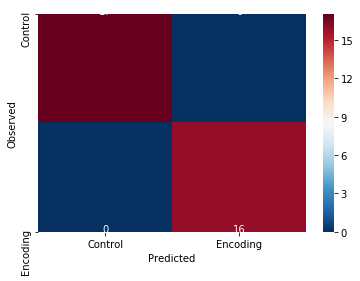

In [115]:
my_first_svc = SVC(kernel='linear') #define the model
my_first_svc.fit(X_train, y_train) #train the model

# predict the training data based on the model
y_pred = my_first_svc.predict(X_train)

# calculate the model accuracy
acc = my_first_svc.score(X_train, y_train)

# calculate the model precision, recall and f1 in one report
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred)

# print results
print('accuracy:', acc)
print(cr)
print(cm)

# plot confusion matrix (training data)
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [122]:
#set up cross-validation to evaluate model performance
#within 10 folds of training set

# predict
y_pred = cross_val_predict(my_first_svc, X_train, y_train,
                           groups=y_train, cv=7)
# scores
acc = cross_val_score(my_first_svc, X_train, y_train,
                     groups=y_train, cv=7)

#Look at accuracy of prediction for each fold of the cross-validation
for i in range(7):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

Fold 0 -- Acc = 0.3333333333333333
Fold 1 -- Acc = 0.16666666666666666
Fold 2 -- Acc = 0.8
Fold 3 -- Acc = 0.75
Fold 4 -- Acc = 0.5
Fold 5 -- Acc = 0.5
Fold 6 -- Acc = 0.75


Accuracy: 0.5151515151515151
               precision    recall  f1-score   support

correctsource       0.53      0.59      0.56        17
       missed       0.50      0.44      0.47        16

     accuracy                           0.52        33
    macro avg       0.51      0.51      0.51        33
 weighted avg       0.51      0.52      0.51        33



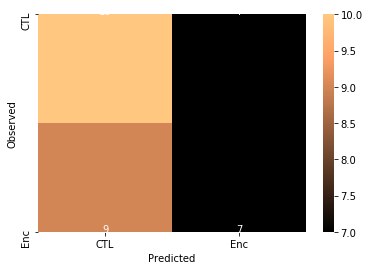

In [123]:
#look at the overall accuracy of the model

overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['CTL','Enc'], columns = ['CTL','Enc'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

Text(0, 0.5, 'subjects')

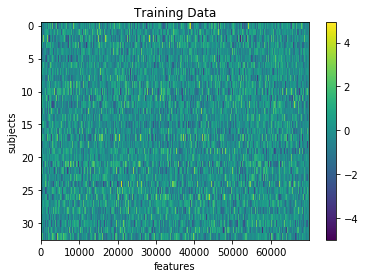

In [118]:
#Scale the training data
scaler = MinMaxScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)

plt.imshow(X_train, aspect='auto')
plt.colorbar()
plt.title('Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Text(0, 0.5, 'subjects')

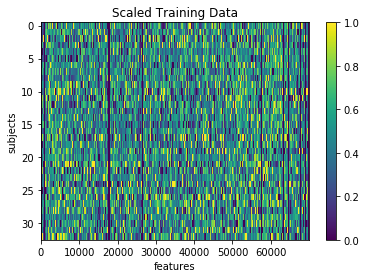

In [119]:
plt.imshow(X_train_scl, aspect='auto')
plt.colorbar()
plt.title('Scaled Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Accuracy: 0.5151515151515151
               precision    recall  f1-score   support

correctsource       0.53      0.59      0.56        17
       missed       0.50      0.44      0.47        16

     accuracy                           0.52        33
    macro avg       0.51      0.51      0.51        33
 weighted avg       0.51      0.52      0.51        33



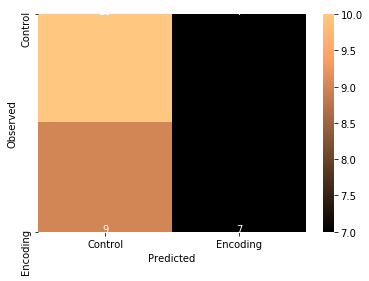

In [120]:
#Repeat steps with scaled data

# predict
y_pred = cross_val_predict(my_first_svc, X_train_scl, y_train,
                           groups=y_train, cv=7)

# get scores
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

# plot
thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

accuracy = 0.5454545454545454
               precision    recall  f1-score   support

correctsource       0.50      0.60      0.55        10
  wrongsource       0.60      0.50      0.55        12

     accuracy                           0.55        22
    macro avg       0.55      0.55      0.55        22
 weighted avg       0.55      0.55      0.55        22



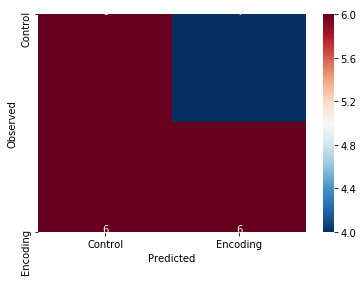

In [94]:
# Test model on unseen data from the test set
# Use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
X_test_scl = scaler.transform(X_test)

my_first_svc.fit(X_train_scl, y_train) # fit to training data
y_pred = my_first_svc.predict(X_test_scl) # classify age class using testing data
acc = my_first_svc.score(X_test_scl, y_test) # get accuracy
cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")